### Imports

In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os

# **Data Cleaning**

### Load datasets

In [46]:
data_files = os.path.join(os.getcwd(), "data") #Alter accordingly if needed

accounts_df = pd.read_csv(os.path.join(data_files, "accounts.csv"))
products_df = pd.read_csv(os.path.join(data_files, "products.csv"))
sales_pipeline_df = pd.read_csv(os.path.join(data_files, "sales_pipeline.csv"))
sales_teams_df = pd.read_csv(os.path.join(data_files, "sales_teams.csv"))

### Remove duplicates



In [47]:
accounts_df.drop_duplicates(inplace=True)
products_df.drop_duplicates(inplace=True)
sales_pipeline_df.drop_duplicates(inplace=True)
sales_teams_df.drop_duplicates(inplace=True)

Fixing this issue: Sales pipeline product column is "GTXPro" without a space, while product's product has "GTX Pro" with space.

In [48]:
sales_pipeline_df['product'] = sales_pipeline_df['product'].replace("GTXPro", "GTX Pro")

In [49]:
#Verifying that worked as intended
print(sales_pipeline_df['product'].unique())

['GTX Plus Basic' 'GTX Pro' 'MG Special' 'GTX Basic' 'MG Advanced'
 'GTX Plus Pro' 'GTK 500']


### Merge datasets

In [50]:
merged_df = (
  sales_pipeline_df
  .merge(sales_teams_df, on="sales_agent", how="left")
  .merge(products_df, on="product", how="left")
  .merge(accounts_df, on="account", how="left")
)
print(merged_df.shape)
merged_df.head(10)

(8800, 18)


,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,manager,regional_office,series,sales_price,sector,year_established,revenue,employees,office_location,subsidiary_of
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0,Dustin Brinkmann,Central,GTX,1096,retail,2001.0,718.62,2448.0,United States,NaN
1,Z063OYW0,Darcel Schlecht,GTX Pro,Isdom,Won,2016-10-25,2017-03-11,4514.0,Melvin Marxen,Central,GTX,4821,medical,2002.0,3178.24,4540.0,United States,NaN
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0,Melvin Marxen,Central,MG,55,retail,2001.0,718.62,2448.0,United States,NaN
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0,Dustin Brinkmann,Central,GTX,550,software,1998.0,2714.90,2641.0,United States,Acme Corporation
4,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0,Summer Sewald,West,GTX,550,services,1982.0,792.46,1299.0,United States,NaN
5,ZNBS69V1,Anna Snelling,MG Special,Ron-tech,Won,2016-10-29,2017-03-01,49.0,Dustin Brinkmann,Central,MG,55,medical,1992.0,3922.42,6837.0,United States,NaN
6,9ME3374G,Vicki Laflamme,MG Special,J-Texon,Won,2016-10-30,2017-03-02,57.0,Celia Rouche,West,MG,55,retail,1989.0,1388.67,3583.0,United States,NaN
7,7GN8Q4LL,Markita Hansen,GTX Basic,Cheers,Won,2016-11-01,2017-03-07,601.0,Celia Rouche,West,GTX,550,entertainment,1993.0,4269.90,6472.0,United States,Massive Dynamic
8,OLK9LKZB,Niesha Huffines,GTX Plus Basic,Zumgoity,Won,2016-11-01,2017-03-03,1026.0,Melvin Marxen,Central,GTX,1096,medical,1984.0,441.08,1210.0,United States,NaN
9,HAXMC4IX,James Ascencio,MG Advanced,NaN,Engaging,2016-11-03,NaN,NaN,Summer Sewald,West,MG,3393,NaN,NaN,NaN,NaN,NaN,NaN


### Convert date columns to proper datetime format

In [51]:
merged_df["engage_date"]=pd.to_datetime(merged_df["engage_date"], errors="coerce")
merged_df["close_date"]=pd.to_datetime(merged_df["close_date"], errors="coerce")

### Handle missing values with mode/median imputation

In [52]:
merged_df.isnull().sum()

,0
opportunity_id,0
sales_agent,0
product,0
account,1425
deal_stage,0
engage_date,500
close_date,2089
close_value,2089
manager,0
regional_office,0


In [53]:
categorical_columns = merged_df.select_dtypes(include="object").columns
numerical_columns = merged_df.select_dtypes(include="float64").columns

#Handling missing values in categorical variables with mode imputation
for col in categorical_columns:
  merged_df[col]=merged_df[col].fillna(merged_df[col].mode()[0])

#Handling missing values in numerical variables with median imputation
for col in numerical_columns:
  if col not in ["close_value", "close_date", "engage_date"]: # these should not be replaced with fake values, since a null value means the deal hasn't been closed yet.
    merged_df[col] = merged_df[col].fillna(merged_df[col].median())

In [54]:
merged_df.isnull().sum()

,0
opportunity_id,0
sales_agent,0
product,0
account,0
deal_stage,0
engage_date,500
close_date,2089
close_value,2089
manager,0
regional_office,0


### Standardize categorical values

In [55]:
for col in categorical_columns:
    merged_df[col] = merged_df[col].astype(str).str.strip().str.upper()

### Handling outliers

In [56]:
for col in numerical_columns:
  if col not in ["close_value", "close_date", "engage_date"]: #these values should not be replaced with fake values, since a null value means the deal hasn't been closed yet.
    Q1 = merged_df[col].quantile(0.25)
    Q3 = merged_df[col].quantile(0.75)
    IQR = Q3-Q1

    lower_side = Q1 -1.5 *IQR
    upper_side = Q3 +1.5 * IQR

    merged_df[col]=merged_df[col].clip(lower=lower_side, upper=upper_side)

In [57]:
cols_to_log = ["close_value", "revenue", "employees"]

for col in cols_to_log:
    merged_df[col + "_log"] = np.log1p(merged_df[col])

merged_df[["close_value", "close_value_log",
           "revenue", "revenue_log",
           "employees", "employees_log"]].head()

,close_value,close_value_log,revenue,revenue_log,employees,employees_log
0,1054.0,6.961296,718.62,6.578723,2448.0,7.803435
1,4514.0,8.415160,3178.24,8.064397,4540.0,8.420903
2,50.0,3.931826,718.62,6.578723,2448.0,7.803435
3,588.0,6.378426,2714.90,7.906879,2641.0,7.879291
4,517.0,6.249975,792.46,6.676403,1299.0,7.170120


# **Data Transformation**

Encode categorical variables

In [58]:
label_enc = LabelEncoder()
for col in categorical_columns:
  merged_df[col] = label_enc.fit_transform(merged_df[col])

Standardize numerical variables

In [59]:
scaler = StandardScaler()
numeric_to_scale = ["year_established", "sales_price"]
merged_df[numeric_to_scale] = scaler.fit_transform(merged_df[numeric_to_scale])

Filtering/dropping unnecessary columns

In [60]:
# opportunity_id is the only column safe to remove because it is a unique identifier and has no predictive or explanatory value for the model.
merged_df.drop(columns=["opportunity_id"], inplace=True)

# **Verifying**

In [61]:
merged_df.isnull().sum()

,0
sales_agent,0
product,0
account,0
deal_stage,0
engage_date,500
close_date,2089
close_value,2089
manager,0
regional_office,0
series,0


In [62]:
merged_df.shape

(8800, 20)

In [63]:
merged_df.head(10)

,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,manager,regional_office,series,sales_price,sector,year_established,revenue,employees,office_location,subsidiary_of,close_value_log,revenue_log,employees_log
0,20,2,8,3,2016-10-20,2017-03-01,1054.0,2,0,1,-0.488043,5,0.677360,718.62,2448.0,14,0,6.961296,6.578723,7.803435
1,6,4,38,3,2016-10-25,2017-03-11,4514.0,3,0,1,0.928795,4,0.797602,3178.24,4540.0,14,0,8.415160,8.064397,8.420903
2,6,6,8,3,2016-10-25,2017-03-07,50.0,3,0,2,-0.883996,5,0.677360,718.62,2448.0,14,0,3.931826,6.578723,7.803435
3,20,1,10,3,2016-10-25,2017-03-09,588.0,2,0,1,-0.695719,7,0.316633,2714.90,2641.0,14,0,6.378426,7.906879,7.879291
4,29,1,34,3,2016-10-25,2017-03-02,517.0,5,2,1,-0.695719,6,-1.607242,792.46,1299.0,14,0,6.249975,6.676403,7.170120
5,0,6,58,3,2016-10-29,2017-03-01,49.0,2,0,2,-0.883996,4,-0.404820,3922.42,6837.0,14,0,3.912023,8.274719,8.830251
6,26,6,40,3,2016-10-30,2017-03-02,57.0,1,2,2,-0.883996,5,-0.765547,1388.67,3583.0,14,0,4.060443,7.236822,8.184235
7,17,1,9,3,2016-11-01,2017-03-07,601.0,1,2,1,-0.695719,1,-0.284578,4269.90,6472.0,14,4,6.400257,8.359580,8.775395
8,21,2,84,3,2016-11-01,2017-03-03,1026.0,3,0,1,-0.488043,4,-1.366758,441.08,1210.0,14,0,6.934397,6.091491,7.099202
9,12,5,35,0,2016-11-03,NaT,NaN,5,2,2,0.385642,5,-0.044093,1698.20,3492.0,14,0,NaN,7.437913,8.158516


### Task 4: Feature Engineering

In [64]:
# Features derived from dates
merged_df["engage_year"] = merged_df["engage_date"].dt.year
merged_df["engage_month"] = merged_df["engage_date"].dt.month
merged_df["engage_dayofweek"] = merged_df["engage_date"].dt.dayofweek

merged_df["days_to_close"] = (merged_df["close_date"] - merged_df["engage_date"]).dt.days
#if there was no close date, then this will be NaN

#These features can highlight patterns like deals closing faster in some months
#days_to_close can help with the opportunity win prediction model, as a longer vs. shorter deal cycle can be correlated with success

In [65]:
# Features derived from account
current_year = pd.Timestamp.now().year
merged_df["account_age"] = current_year - merged_df["year_established"]
#Can be useful for Lead Scoring & Account Health models

In [66]:
#Features derived from numerical columns
# Revenue per employee
merged_df["rev_per_employee"] = merged_df.apply(
    lambda x: x["revenue"] / x["employees"] if x["employees"] > 0 else np.nan, axis=1
)
#Can be used for account health scoring model, as accounts that have higher revenue for each employee can indicate stronger clients or more efficiency

In [67]:
merged_df["has_close_date"] = merged_df["close_date"].notna().astype(int)
#Flagging deals without a close date
#Informative for Opportunity Win Prediction model, so that the model knows if the deal isn't closed yet

In [70]:
merged_df.head(10)

,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,manager,regional_office,series,...,close_value_log,revenue_log,employees_log,engage_year,engage_month,engage_dayofweek,days_to_close,account_age,rev_per_employee,has_close_date
0,20,2,8,3,2016-10-20,2017-03-01,1054.0,2,0,1,...,6.961296,6.578723,7.803435,2016.0,10.0,3.0,132.0,2024.322640,0.293554,1
1,6,4,38,3,2016-10-25,2017-03-11,4514.0,3,0,1,...,8.415160,8.064397,8.420903,2016.0,10.0,1.0,137.0,2024.202398,0.700053,1
2,6,6,8,3,2016-10-25,2017-03-07,50.0,3,0,2,...,3.931826,6.578723,7.803435,2016.0,10.0,1.0,133.0,2024.322640,0.293554,1
3,20,1,10,3,2016-10-25,2017-03-09,588.0,2,0,1,...,6.378426,7.906879,7.879291,2016.0,10.0,1.0,135.0,2024.683367,1.027982,1
4,29,1,34,3,2016-10-25,2017-03-02,517.0,5,2,1,...,6.249975,6.676403,7.170120,2016.0,10.0,1.0,128.0,2026.607242,0.610054,1
5,0,6,58,3,2016-10-29,2017-03-01,49.0,2,0,2,...,3.912023,8.274719,8.830251,2016.0,10.0,5.0,123.0,2025.404820,0.573705,1
6,26,6,40,3,2016-10-30,2017-03-02,57.0,1,2,2,...,4.060443,7.236822,8.184235,2016.0,10.0,6.0,123.0,2025.765547,0.387572,1
7,17,1,9,3,2016-11-01,2017-03-07,601.0,1,2,1,...,6.400257,8.359580,8.775395,2016.0,11.0,1.0,126.0,2025.284578,0.659750,1
8,21,2,84,3,2016-11-01,2017-03-03,1026.0,3,0,1,...,6.934397,6.091491,7.099202,2016.0,11.0,1.0,122.0,2026.366758,0.364529,1
9,12,5,35,0,2016-11-03,NaT,NaN,5,2,2,...,NaN,7.437913,8.158516,2016.0,11.0,3.0,NaN,2025.044093,0.486312,0


In [72]:
merged_df[['employees', 'revenue']].head()

,employees,revenue
0,2448.0,718.62
1,4540.0,3178.24
2,2448.0,718.62
3,2641.0,2714.90
4,1299.0,792.46


In [71]:
merged_df.columns
#There are a lot of columns now due to added derived features, so we should figure out which ones to drop.

Index(['sales_agent', 'product', 'account', 'deal_stage', 'engage_date',
       'close_date', 'close_value', 'manager', 'regional_office', 'series',
       'sales_price', 'sector', 'year_established', 'revenue', 'employees',
       'office_location', 'subsidiary_of', 'close_value_log', 'revenue_log',
       'employees_log', 'engage_year', 'engage_month', 'engage_dayofweek',
       'days_to_close', 'account_age', 'rev_per_employee', 'has_close_date'],
      dtype='object')

In [74]:
# Compute correlation matrix
corr_matrix = merged_df[numerical_columns].corr()

# Find highly correlated pairs
high_corr_pairs = []
for i, col1 in enumerate(numerical_columns):
    for col2 in numerical_columns[i+1:]:  # avoid repeating pairs and self-correlation
        corr_val = corr_matrix.loc[col1, col2]
        if abs(corr_val) > 0.9:
            high_corr_pairs.append((col1, col2, corr_val))

# Display results
if high_corr_pairs:
    print("Column pairs with correlation > 0.9:")
    for col1, col2, corr_val in high_corr_pairs:
        print(f"{col1} & {col2} --> {corr_val:.2f}")
else:
    print("No highly correlated column pairs were found")


Highly correlated column pairs (correlation > 0.9):
revenue & employees --> 0.95


## Task 5: EDA

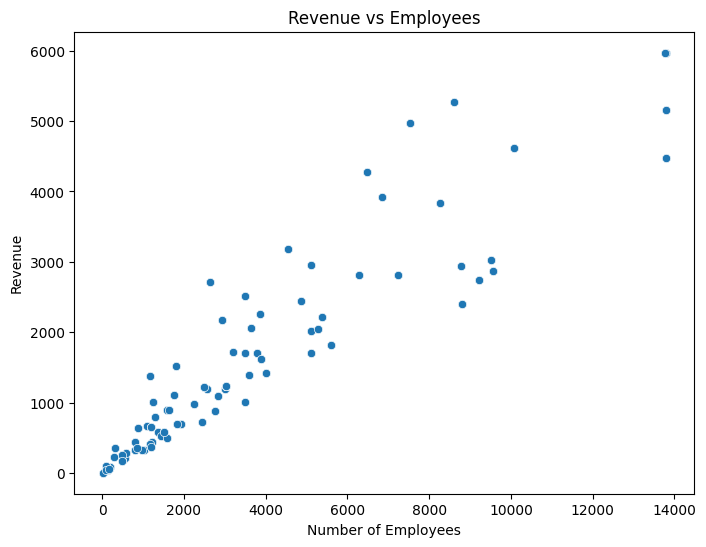

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(data=merged_df, x="employees", y="revenue")
plt.title("Revenue vs Employees")
plt.xlabel("Number of Employees")
plt.ylabel("Revenue")
plt.show()
#Linear relationship between the number of employees and the revenue!

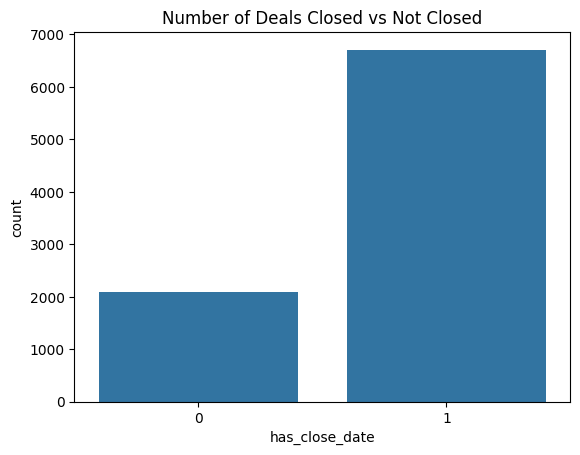

In [87]:
sns.countplot(x='has_close_date', data=merged_df)
plt.title("Number of Deals Closed vs Not Closed")
plt.show()

In [82]:
# Summary statistics for numeric features
numeric_summary = merged_df.describe().T
print(numeric_summary[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']])

                   count                           mean          std  \
sales_agent       8800.0                        13.8975     8.678309   
product           8800.0                       3.457045     1.826544   
account           8800.0                      39.986591    21.886514   
deal_stage        8800.0                       1.839432     1.208003   
engage_date         8300  2017-06-14 08:35:06.216867584          NaN   
close_date          6711  2017-08-01 03:32:25.641484032          NaN   
close_value       6711.0                    1490.915512  2320.670773   
manager           8800.0                       2.734318     1.615108   
regional_office   8800.0                       0.941477      0.85809   
series            8800.0                       1.343523     0.484389   
sales_price       8800.0                           -0.0     1.000057   
sector            8800.0                       4.955795     2.304815   
year_established  8800.0                            0.0     1.00

In [83]:
missing_summary = merged_df.isnull().sum()
print(missing_summary[missing_summary > 0])

engage_date          500
close_date          2089
close_value         2089
close_value_log     2089
engage_year          500
engage_month         500
engage_dayofweek     500
days_to_close       2089
dtype: int64
